Q: How much do mean and std change when subsetting the fingerprinted data (as an attack)?

In [1]:
import os
os.chdir("C:\\Users\\tsarcevic\\PycharmProjects\\fingerprinting-toolbox")
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datasets import GermanCredit, read_fingerprinted_data
from attacks import HorizontalSubsetAttack
from parameter_guidelines.guidelines import *

import pickle
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [3]:
fp_data = read_fingerprinted_data('german_credit', 20, 'universal', 1.11, 1, 8, 1, 0)

In [4]:
mean_fp = fp_data.select_dtypes(include='int64').drop(['Id', 'target'], axis=1).mean()
std_fp = fp_data.select_dtypes(include='int64').drop(['Id', 'target'], axis=1).std()

# THE EVALUATION

In [5]:
attack_strenghts = [i*0.1 for i in range(1,10)]
attack = HorizontalSubsetAttack()

In [6]:
utilities = {'mean': dict(), 'std': dict()}

In [7]:
for s in attack_strenghts:
    # apply attack (1 ds is enough for a demo)
    data_subset = attack.run(fp_data, s, random_state=10)
    # calc dmean and dstd
    mean_attack = data_subset.select_dtypes(include='int64').drop(['Id', 'target'], axis=1).mean()
    d_mean_norm = (mean_attack - mean_fp) / mean_fp
    utilities['mean'][s] = d_mean_norm
    std_attack = data_subset.select_dtypes(include='int64').drop(['Id', 'target'], axis=1).std()
    d_std_norm = (std_attack - std_fp) / std_fp
    utilities['std'][s] = d_std_norm

In [8]:
with open('parameter_guidelines/evaluation/german_credit/utility_ml_baseline.pickle', 'rb') as infile:
    baseline = pickle.load(infile)
for model in baseline:
    baseline[model] = np.mean(baseline[model])

In [40]:
models = {'gb': GradientBoostingClassifier(random_state=0),
         'knn': KNeighborsClassifier(),
         'rf': RandomForestClassifier(random_state=0),
          'lr': LogisticRegression(random_state=0),
          'mlp': MLPClassifier(random_state=0),
          'svm': SVC(random_state=0)}
model_names = {'mlp':'Multi-Layer Perceptron', 
            'knn': 'k-NN',
             'gb': 'Gradient Boosting', 
             'rf': 'Random Forest', 
             'svm': 'SVM', 
             'lr': 'Logistic Regression'}

In [10]:
for model in baseline.keys():
    utilities[model] = attack_utility(models[model], GermanCredit().preprocessed(fp_data=fp_data), 'target', attack)
    utilities[model] = {round(1.0-key, 1): np.mean(utility) for key, utility in utilities[model].items()}

In [35]:
pd.DataFrame(utilities['mean'].values()).columns

Index(['duration', 'credit_amount', 'installment_rate', 'residence_since',
       'age', 'existing_credits', 'liable_people'],
      dtype='object')

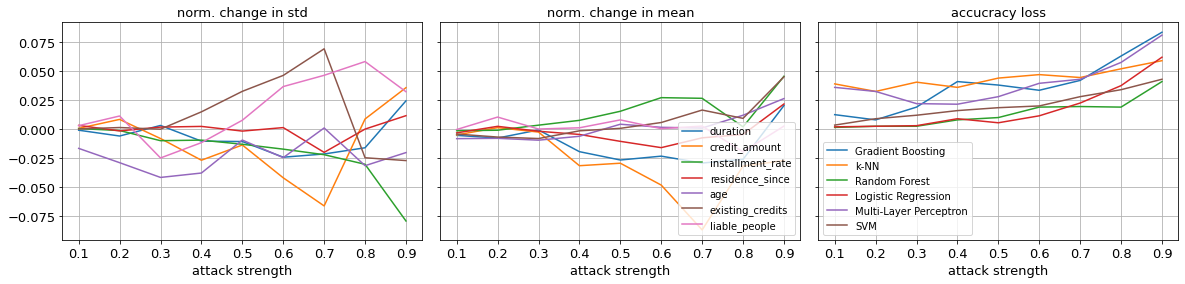

In [85]:
fig, axs = plt.subplots(1,3, figsize=(20,4), sharey=True)
fontsize=13

axs[0].plot(utilities['std'].keys(), utilities['std'].values())
axs[0].set_title('norm. change in std', fontsize=fontsize)

axs[1].plot(utilities['mean'].keys(), utilities['mean'].values(), label=pd.DataFrame(utilities['mean'].values()).columns)
axs[1].set_title('norm. change in mean', fontsize=fontsize)
axs[1].legend()

for model in models:
    axs[2].plot(utilities[model].keys(), [baseline[model]-u for u in utilities[model].values()],  label=model_names[model])
axs[2].set_title('accucracy loss', fontsize=fontsize)
axs[2].legend()

plt.subplots_adjust(wspace=0.05, hspace=0)
for ax in axs:
    ax.grid()
    ax.set_xlabel('attack strength', fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)

#plt.rcParams.update({'font.size': 10})